   Updating registry at `C:\Users\saman\.julia\registries\General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
   Updating `C:\Users\saman\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\saman\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `C:\Users\saman\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\saman\.julia\environments\v1.4\Manifest.toml`
 [no changes]


wer


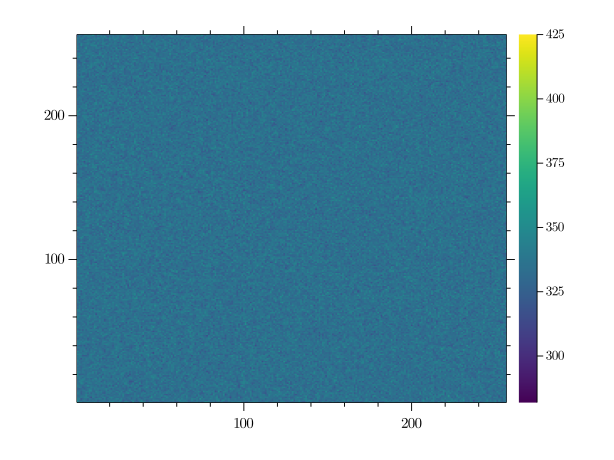

In [1]:
using Pkg
Pkg.add("Distributions")
Pkg.add("GR")

using Distributions
using GR

num_photons = 500
num_pixels  = 256
#mu_p        = num_photons * np.ones((num_pixels, num_pixels))
println("wer")

function fnc_1()
    num_photons = 500
    num_pixels  = 256
    A = num_photons * ones(Integer,num_pixels,num_pixels)
    x = Array(1:num_pixels)
    y = Array(1:num_pixels)
    z = A[x,y]

    heatmap(A)
end

#fnc_1()

function fnc_2()
    num_photons = 500
    num_pixels  = 256
    seed       = 42
    #rs         = np.random.RandomState(seed)
    A = num_photons * ones(Float64,num_pixels,num_pixels)
    x = Poisson(num_photons)
    for i in 1:num_pixels
        for j in 1:num_pixels
            A[i,j] = rand(x)
        end
    end
    heatmap(A)
    histogram(A; nbins = 650-350)
    #shot_noise = rs.poisson(num_photons, (num_pixels, num_pixels))

    #fig, (ax0, ax1) = plt.subplots(ncols=2)
    #img0 = ax0.imshow(mu_p, vmin=400, vmax=600)
    #ax0.set_xticks([])
    #ax0.set_yticks([])
    #ax0.set_title('No shot noise')

    #divider = make_axes_locatable(ax0)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #cb0 = plt.colorbar(img0, cax=cax)
    #cb0.set_ticks([])

    #img1 = ax1.imshow(shot_noise, vmin=400, vmax=600)
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    #ax1.set_title('Shot noise')

    #divider = make_axes_locatable(ax1)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #cb1 = plt.colorbar(img1, cax=cax)
    #cb1.set_label('Photons')
end

function fnc_3()
    num_photons = 500
    num_pixels  = 256
    seed       = 42
    quantum_efficiency = 0.69

    dark_noise = 2.29

    #rs         = np.random.RandomState(seed)
    shot_noise = num_photons * ones(Float64,num_pixels,num_pixels)
    electrons = ones(Float64,num_pixels,num_pixels)
    dark_noise_dist = ones(Float64,num_pixels,num_pixels)
    elex_plus_darknoise = ones(Float64,num_pixels,num_pixels)

    x = Poisson(num_photons)
    norm = Normal(dark_noise)

    for i in 1:num_pixels
        for j in 1:num_pixels
            elem = rand(x)
            shot_noise[i,j] = elem
            electrons[i,j] = round((quantum_efficiency * elem), digits=3)
            #dark_noise_dist = rand(norm);
            elex_plus_darknoise[i,j] = rand(norm) + electrons[i,j]
        end
    end

    electrons

    #heatmap(shot_noise, clim=[200.,600.])
    #heatmap(electrons, clim=[200.,600.])
    heatmap(elex_plus_darknoise, clim=[200.,600.])

end


fnc_3()